In [680]:
import pandas as pd 
import datetime
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from pylab import rcParams

%matplotlib inline

In [681]:
# загружаем данные о заказах в табличку

orders = pd.read_csv('train.csv', sep =',').dropna()

orders['date'] = pd.to_datetime(orders.date,format='%d.%m.%Y') 
orders.index  = orders.date
orders.drop('date', axis = 1, inplace = True)

train_orders = orders.sort_values('date', ascending = True).iloc[:-4]
test_orders = orders.sort_values('date', ascending = True).iloc[-4:]

train_orders.head(5)

,date_id,orders
date,,
2018-12-27,1,17
2018-12-28,2,29
2018-12-29,3,30
2018-12-30,4,24
2018-12-31,5,11


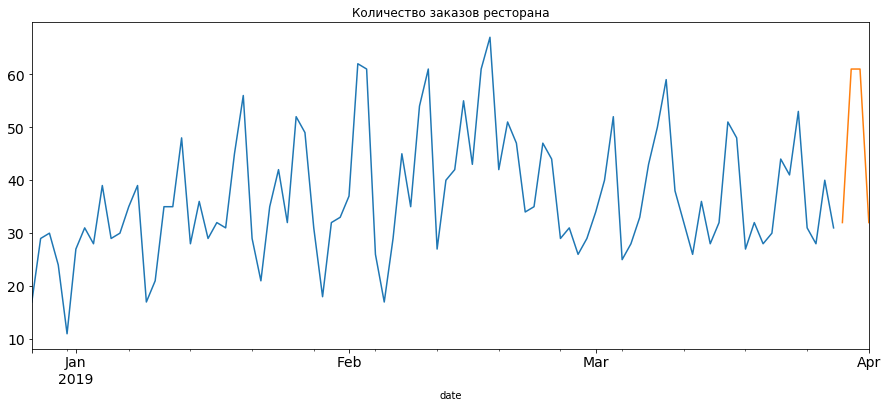

In [682]:
# смотрим на разделение train/test

train_orders.orders.plot( figsize=(15,6),title= 'Количество заказов ресторана', fontsize=14)
test_orders.orders.plot( figsize=(15,6),title= 'Количество заказов ресторана', fontsize=14)

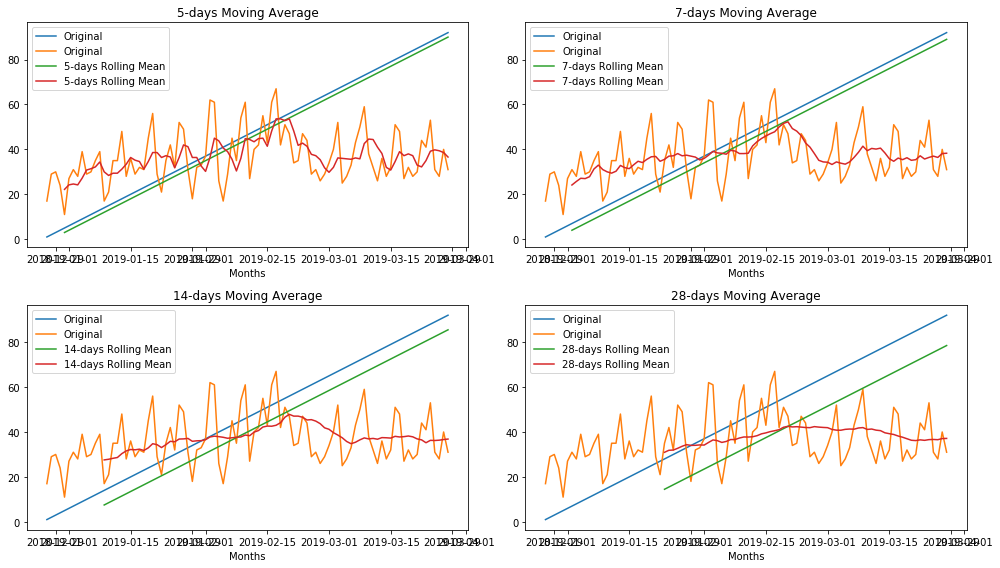

In [683]:
# визуализируем данные

fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)

axes[0][0].plot(train_orders.index, train_orders, label='Original')
axes[0][0].plot(train_orders.index, train_orders.rolling(window=5).mean(), label='5-days Rolling Mean')
axes[0][0].set_xlabel("Months")
axes[0][0].set_title("5-days Moving Average")
axes[0][0].legend(loc='best')

axes[0][1].plot(train_orders.index, train_orders, label='Original')
axes[0][1].plot(train_orders.index, train_orders.rolling(window=7).mean(), label='7-days Rolling Mean')
axes[0][1].set_xlabel("Months")
axes[0][1].set_title("7-days Moving Average")
axes[0][1].legend(loc='best')

axes[1][0].plot(train_orders.index, train_orders, label='Original')
axes[1][0].plot(train_orders.index, train_orders.rolling(window=14).mean(), label='14-days Rolling Mean')
axes[1][0].set_xlabel("Months")
axes[1][0].set_title("14-days Moving Average")
axes[1][0].legend(loc='best')

axes[1][1].plot(train_orders.index, train_orders, label='Original')
axes[1][1].plot(train_orders.index, train_orders.rolling(window=28).mean(), label='28-days Rolling Mean')
axes[1][1].set_xlabel("Months")
axes[1][1].set_title("28-days Moving Average")
axes[1][1].legend(loc='best')

plt.tight_layout()
plt.show()

In [684]:
train_orders['weekday'] = train_orders.index.weekday
train_orders['week'] = train_orders.index.week

train_orders_pivot = pd.pivot_table(train_orders, values = "orders", columns = "week", index = "weekday")

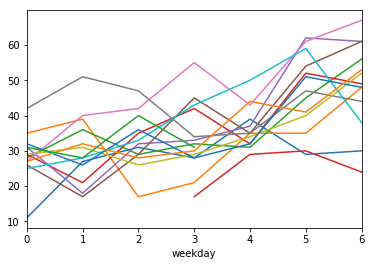

In [685]:
train_orders_pivot.plot(legend = False)

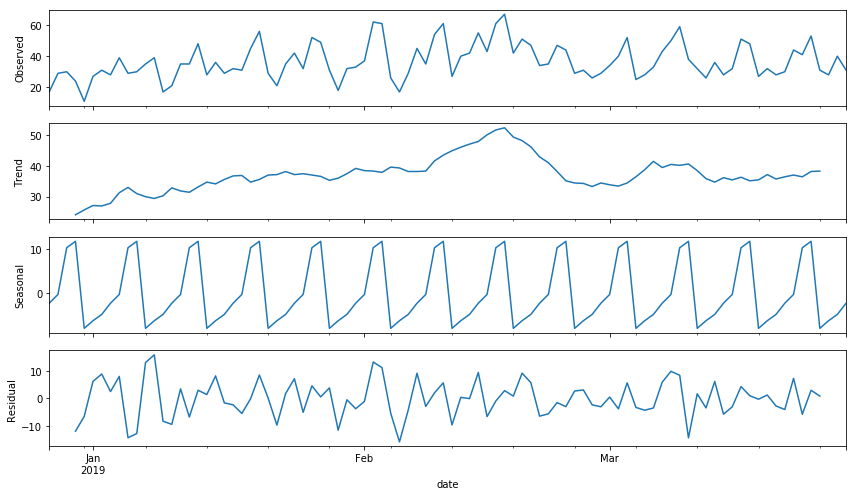

In [686]:
rcParams['figure.figsize'] = 12, 7
sm.tsa.seasonal_decompose(train_orders.orders).plot()
plt.show()

In [687]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.05):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.values,autolag='AIC' )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

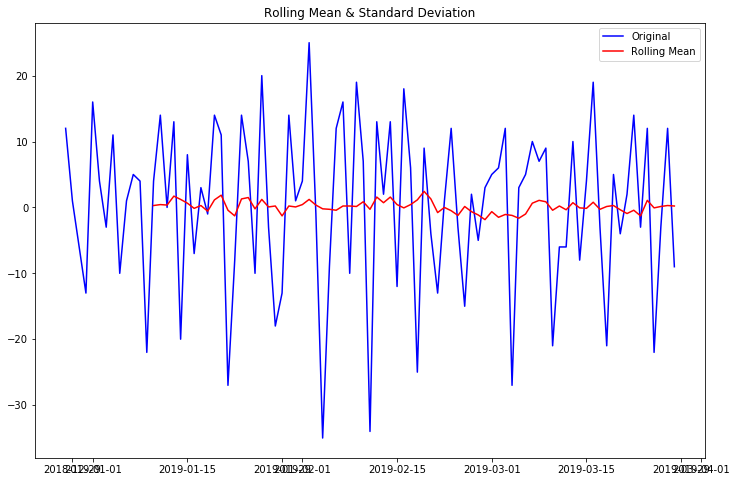

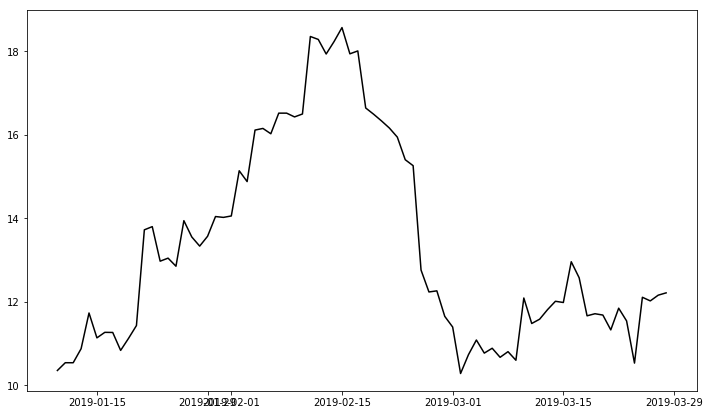

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -5.725809e+00
p-value                        6.775705e-07
#Lags Used                     6.000000e+00
Number of Observations Used    8.400000e+01
Critical Value (1%)           -3.510712e+00
Critical Value (5%)           -2.896616e+00
Critical Value (10%)          -2.585482e+00
dtype: float64


In [688]:
train_orders['orders_diff'] = train_orders.orders - train_orders.orders.shift(1)
train_orders.dropna(inplace = True)
test_stationarity(train_orders['orders_diff'], window = 14)

/usr/local/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


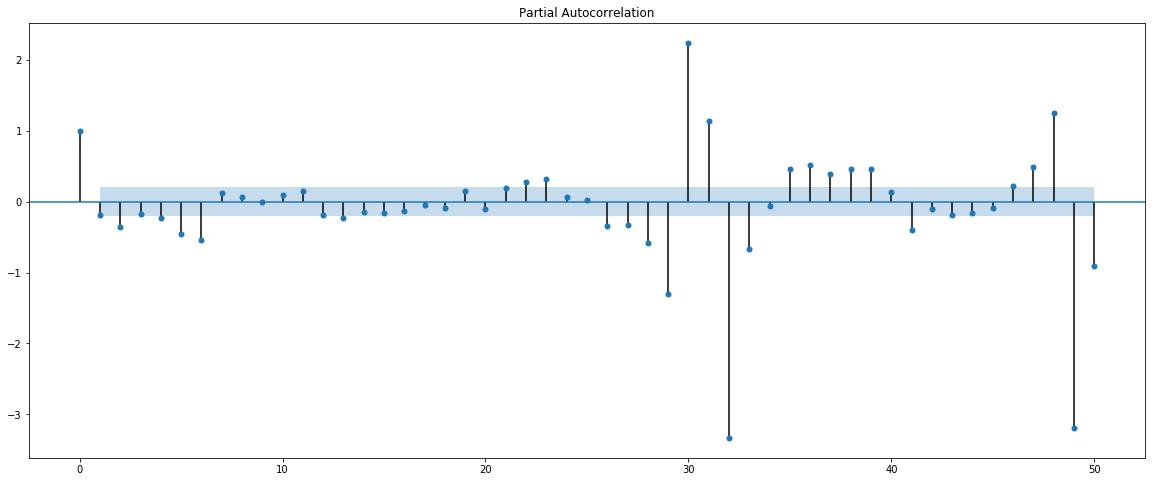

In [689]:
import statsmodels.api as sm
fig, ax = plt.subplots(figsize=(20,8))
sm.graphics.tsa.plot_pacf(train_orders.orders_diff.values, lags=50,ax = ax)
plt.show()

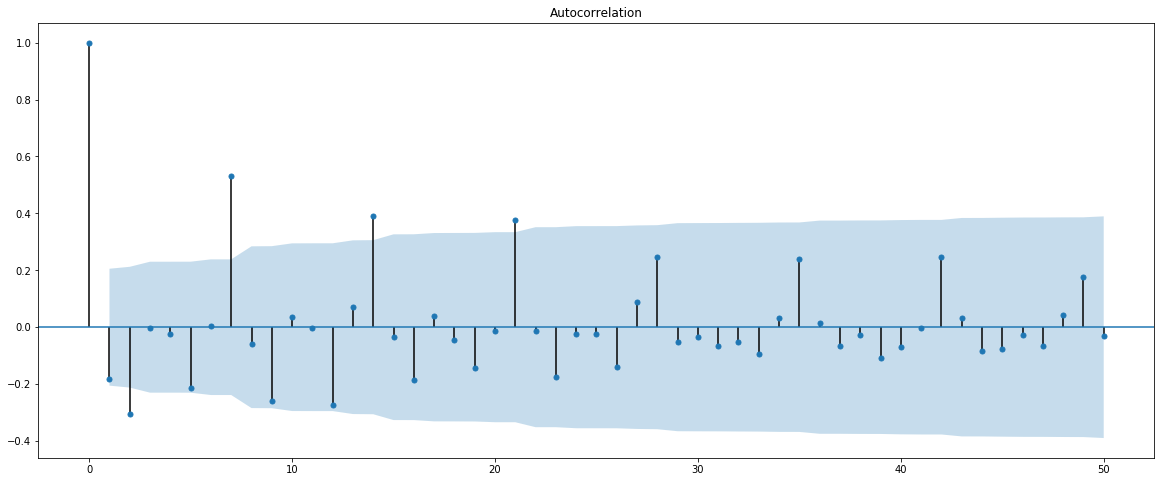

In [690]:
fig, ax = plt.subplots(figsize=(20,8))
sm.graphics.tsa.plot_acf(train_orders.orders_diff.values, lags=50,ax = ax)
plt.show()

In [703]:
# из графиков выше очевидна ярковыраженная сезонность

d = [1]
D = [1]

s = [14]

ps = range(0, 2)
Ps = range(0, 2)

qs = range(5, 7)
Qs = range(0, 2)

In [692]:
from itertools import product

parameters = product(d, D, s, ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [693]:
%%time
import warnings
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(train_orders.orders, order=(param[3], param[0], param[4]), 
                                        seasonal_order=(param[5], param[1], param[6], param[2])).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 38.8 s, sys: 3.46 s, total: 42.2 s
Wall time: 21.2 s


In [694]:
print(best_model.summary().tables[0])
print(best_model.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                             orders   No. Observations:                   91
Model:             SARIMAX(0, 1, 5)x(0, 1, 1, 14)   Log Likelihood                -282.091
Date:                            Thu, 25 Apr 2019   AIC                            578.181
Time:                                    21:51:00   BIC                            594.497
Sample:                                12-28-2018   HQIC                           584.702
                                     - 03-28-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6201      0.132     -4.706      0.000      -0.878      -0.362
ma.L2         -0.2620      0.150   

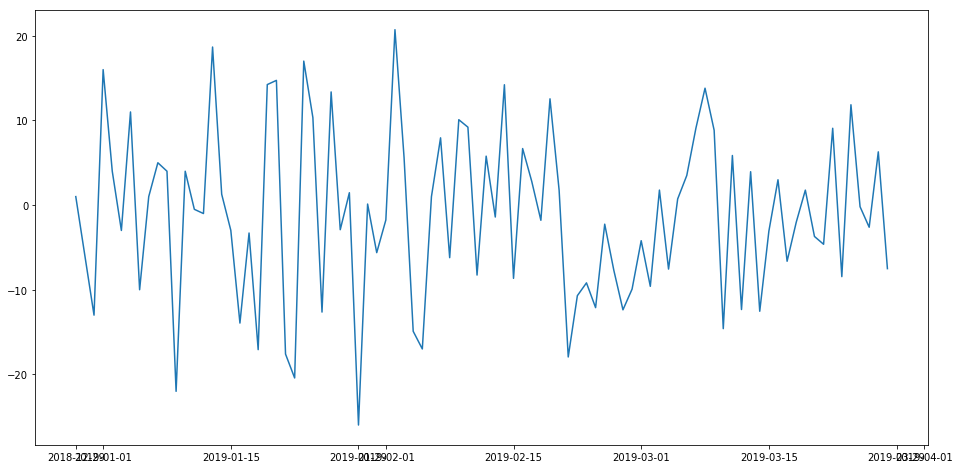

In [695]:
plt.figure(figsize=(16,8))
plt.plot(best_model.resid[1:])
plt.show()

In [697]:
forecast = best_model.predict(start = train_orders.shape[0], end = train_orders.shape[0]+test_orders.shape[0])

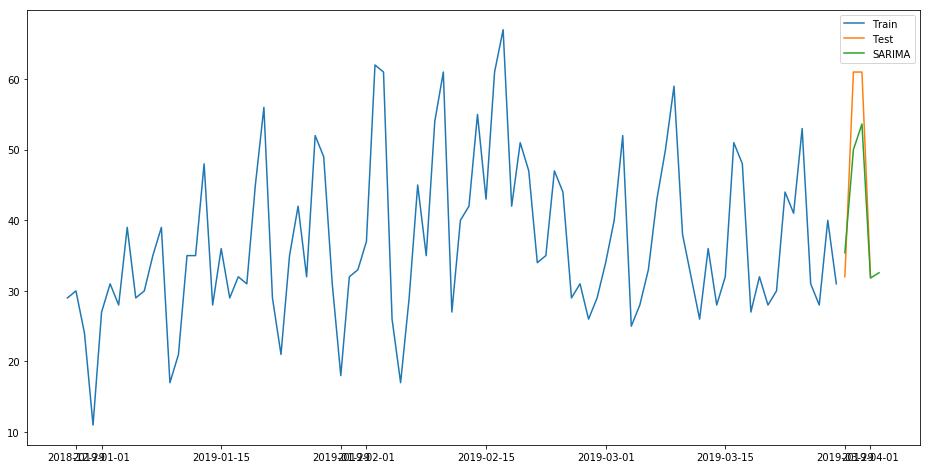

In [704]:
plt.figure(figsize=(16,8))
plt.plot(train_orders.orders[:], label='Train')
plt.plot(test_orders.orders[:], label='Test')
plt.plot(forecast[:], label='SARIMA')
plt.legend(loc='best')
plt.show()

In [705]:
all_orders = pd.read_csv('train.csv', sep =',').dropna()

all_orders['date'] = pd.to_datetime(all_orders.date,format='%d.%m.%Y') 
all_orders.index  = all_orders.date
all_orders.drop('date', axis = 1, inplace = True)

all_orders = all_orders.sort_values('date', ascending = True)

ans_forecast = best_model.predict(start = all_orders.shape[0]-1, end = all_orders.shape[0]+6)
train_orders.shape[0]
ans_forecast

2019-04-02    32.573473
2019-04-03    32.675413
2019-04-04    37.196009
2019-04-05    40.158397
2019-04-06    48.443936
2019-04-07    48.301044
2019-04-08    30.015646
2019-04-09    32.444088
Freq: D, dtype: float64

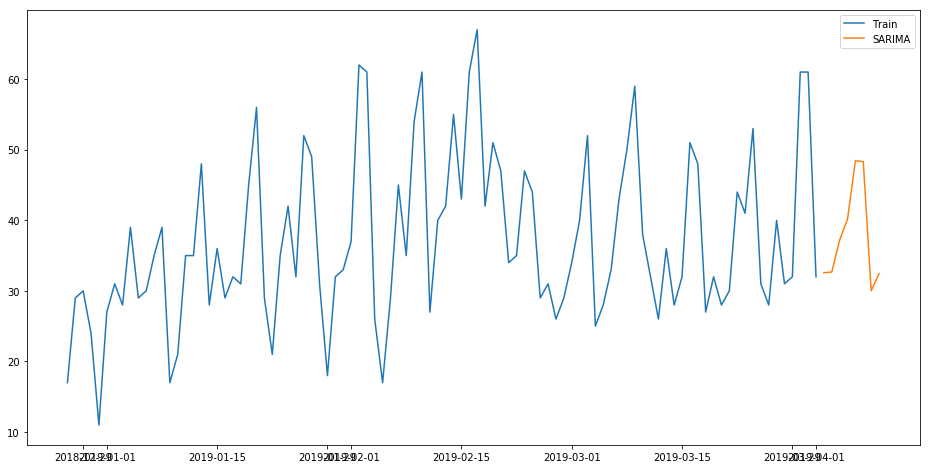

In [706]:
plt.figure(figsize=(16,8))
plt.plot(all_orders.orders[:], label='Train')
plt.plot(ans_forecast[:], label='SARIMA')
plt.legend(loc='best')
plt.show()

In [707]:
df = pd.DataFrame({'date_id': [97, 98, 99, 100, 101, 102, 103, 104],
                    'orders': list([n for n in ans_forecast])})
df

,date_id,orders
0,97,32.573473
1,98,32.675413
2,99,37.196009
3,100,40.158397
4,101,48.443936
5,102,48.301044
6,103,30.015646
7,104,32.444088


In [708]:
df.to_csv('submit.csv', index=False)